# Problem 1 (Quickdraw)

In [1]:
import os
import numpy as np
import torch
import torch.utils.data as data
import argparse
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

## Dataloader Functions

In [2]:
def load_dataset(root, mtype):
    num_classes = 0
    with open("./DataUtils/class_names.txt", "r") as f:
        for line in f:
            num_classes = num_classes+1

    # load data from cache
    if os.path.exists(os.path.join(root, mtype+'.npz')):
        data_cache = np.load(os.path.join(root, mtype+'.npz'))
        return data_cache["data"].astype('float32'), \
            data_cache["target"].astype('int64'), num_classes

class Dataset(data.Dataset):
    def __init__(self, mtype, root='Dataset', transform=None):
        self.data, self.target, self.num_classes = load_dataset(root, mtype)
        self.data = torch.from_numpy(self.data)
        self.target = torch.from_numpy(self.target)
        self.transform = transform
    def __getitem__(self, index):
        return self.data[index], self.target[index]

    def __len__(self):
        return len(self.data)

    def get_number_classes(self):
        return self.num_classes
    
CLASSES=['airplane', 'basket', 'basketball', 'bed', 'bus', 'calculator', 'cookie', 'eyeglasses', 'mushroom', 'pizza']
         

## Define Network

In [3]:
### Define CNN Architecture 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1,10, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.Conv2d(10,20, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(20,30, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(30,40, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(40,50, kernel_size=2, padding=1),
            nn.LeakyReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(33800,1000),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(1000,100),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(100,10)
        )
    def forward(self, x):
        out = self.layer(x)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out


## Proceed to Setup The Network

In [4]:
Batch_Size = 64
train_data = Dataset(mtype="train", root='Dataset')
train_loader = torch.utils.data.DataLoader(train_data, batch_size=Batch_Size, shuffle=True)

test_data = Dataset(mtype="test", root='Dataset')
test_loader = torch.utils.data.DataLoader(test_data, batch_size=Batch_Size, shuffle=False)

num_classes = train_data.get_number_classes()
print("Number of Classes: ", num_classes)

Number of Classes:  10


In [5]:
## Setup Network
net = None
model = Net().cuda()
print(model)

## Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50,eta_min=0.00001)
loss = nn.CrossEntropyLoss()

Net(
  (layer): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(30, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(40, 50, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.01)
  )
  (fc): Sequential(
    (0): Linear(in_features=33800, out_features=1000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=1000, out_features=100, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)


  2%|▏         | 1/50 [00:06<05:29,  6.73s/it]

Epoch[1/50], loss:1.5073


 42%|████▏     | 21/50 [02:23<03:22,  6.98s/it]

Epoch[21/50], loss:0.0183


 82%|████████▏ | 41/50 [04:44<01:03,  7.07s/it]

Epoch[41/50], loss:0.0051


100%|██████████| 50/50 [05:48<00:00,  6.97s/it]

Epoch[50/50], loss:0.0056


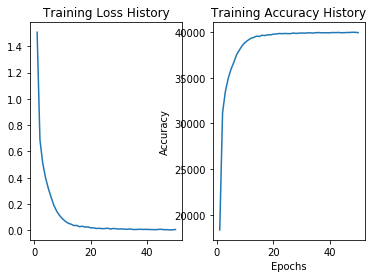

Test Total Loss:  128.80158316344023
Accuracy Total:  8955.0
Accuracy Percentage:  89.55


In [6]:
def train(epochs=50):
   
    # Clear Cuda Cache
    torch.cuda.empty_cache()
    
    # Numpy Array for Loss Functions
    loss_history = np.zeros(epochs)
    x_range = np.arange(1, epochs+1)
    accuracy_history = np.zeros(epochs)
    for i in tqdm(range(epochs)):
        loss_avg = 0
        accuracy = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            # Data View
            data = data.view(-1,1, 28, 28)
            data /= 255.0

            # Sent Inputs to CUDA
            data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            # Feedforward
            y_hat = model(data)

            # Calculate Loss
            Loss = loss(y_hat, target)

            # Update Gradients
            Loss.backward()
            loss_avg += Loss.item()
            
            # Accuracy
            y_hat_pred = y_hat.data.max(1)[1]
            accuracy   += float(y_hat_pred.eq(target.data).sum())

            # Prooced to Next Step
            optimizer.step()

        loss_history[i] = loss_avg / len(train_loader)
        if i % 20 == 0 or i == (epochs -1):      
            print('Epoch[{}/{}], loss:{:.4f}'.format(i+1,epochs, loss_avg/len(train_loader)))
        accuracy_history[i] = accuracy
        
    # Proceed to Test the Model 
    loss_avg_test = 0
    accuracy_test = 0
    
    for batch_idx, (data, target) in enumerate(test_loader):
        with torch.no_grad():
            data = data.view(-1,1, 28, 28)
            data /= 255.0

            # Sent Inputs to CUDA
            data, target = data.cuda(), target.cuda()
            
            # Feed Forward
            y_hat = model(data)
            
            # Calculate Loss
            Loss = loss(y_hat, target)
            loss_avg_test += Loss.item()
            
            # Accuracy
            y_hat_pred = y_hat.data.max(1)[1]
            accuracy_test  += float(y_hat_pred.eq(target.data).sum())
    
    # Proceed to Plot the Image
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(x_range, loss_history)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    ax1.set_title("Training Loss History")
    ax2.plot(x_range, accuracy_history)
    ax2.set_title("Training Accuracy History")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()
    
    # Print Final Parts
    print("Test Total Loss: ", loss_avg_test)
    print("Accuracy Total: ", accuracy_test)
    print("Accuracy Percentage: ", (accuracy_test/ 10000) * 100)
    
train()

# Problem 2 AutoEncoders

In [3]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm.notebook import trange, tqdm
from tqdm import tqdm_notebook
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics


## Define Dataset

In [4]:
img_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

train_data = torchvision.datasets.MNIST("./data", train=True, download=True, transform=img_transform)
test_data  = torchvision.datasets.MNIST("./data", train=False, download=True, transform=img_transform)

print(len(train_data))
print(len(test_data))

60000
10000


In [5]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=True)

## Regular Autoencoder

### Define Network

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12,3),
        )
        self.Decoder = nn.Sequential(
            nn.Linear(3,12),
            nn.ReLU(), 
            nn.Linear(12,64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128,28*28),
            nn.Tanh()
        )
    def forward(self,x):
        x = self.Encoder(x)
        x = self.Decoder(x)
        return x
    def forward2(self,x):
        x = self.Encoder(x)
        return x

In [11]:
model = AutoEncoder().cuda()
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)

### Train AutoEncoder

/home/franciscoAML/anaconda3/envs/AI/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


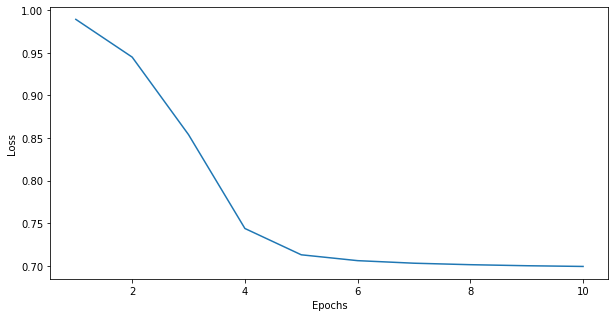

In [12]:
def train(epochs=10):
    loss_history = np.zeros(epochs)
    x_range = np.arange(1, epochs+1)
    for i in tqdm_notebook(range(epochs)):
        loss_avg = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.view(data.size(0), -1)
            data, target = data.cuda(), target.cuda()
            
            # Zero Grad
            optimizer.zero_grad()
            
            # Forward Pass
            y_hat = model(data)
            Loss = loss(y_hat, data)
            
            # Keep Sum of Loss
            loss_avg += Loss.item()
            
            # Backward Pass
            Loss.backward()
            
            # Step Forward
            optimizer.step()
            
        # Save Loss History    
        loss_history[i] = loss_avg / len(train_loader)
        
    # Matplotlib
    plt.figure(figsize=(10,5))
    plt.plot(x_range, loss_history)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
            
            
train()
            

### Testing Final Layer of Encoder

In [13]:
### Proceed to Test The AutoEncoder

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=1, shuffle=True)

def test():
    loss_avg = 0
    X = np.zeros((len(train_loader),3))
    X_original = np.zeros((len(train_loader), 28*28))
    Y = []
    target_list  = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(data.size(0), -1)
        data, target = data.cuda(), target.cuda()
            
        # Zero Grad
        with torch.no_grad():   
            # Forward Pass
            y_hat = model.forward2(data)

            y_hat = y_hat.detach().cpu().numpy()
            y_hat = np.asarray(y_hat)
            
            # Append Values
            X[batch_idx] = y_hat
            X_original[batch_idx] = data.detach().cpu().numpy()
            target = target.detach().cpu().numpy()
            Y.append(target)
    
    # Declare Logistic Equation
    Y = np.asarray(Y).flatten()
    
    # Original Data
    clf1 = LogisticRegression(random_state=1, max_iter=1e4).fit(X_original,Y)
    y_hat = clf1.predict(X_original)
    print("Original Accuracy: ", accuracy_score(y_hat, Y))
    
    clf = LogisticRegression(random_state=0, max_iter=1e4).fit(X, Y)
    y_hat = clf.predict(X)
    print("Training Accuracy: ", accuracy_score(y_hat, Y))
    
test()

Original Accuracy:  0.9425
Training Accuracy:  0.2971666666666667


### Testing Output of Decoder

In [14]:
def test2():
    X = np.zeros((len(train_loader),28*28))
    Y = []
    target_list  = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(data.size(0), -1)
        data, target = data.cuda(), target.cuda()
            
        # Zero Grad
        with torch.no_grad():   
            # Forward Pass
            y_hat = model.forward(data)

            y_hat = y_hat.detach().cpu().numpy()
            y_hat = np.asarray(y_hat)
            
            # Append Values
            X[batch_idx] = y_hat
            target = target.detach().cpu().numpy()
            Y.append(target)
    
    # Declare Logistic Equation
    Y = np.asarray(Y).flatten()
    clf = LogisticRegression(random_state=0, max_iter=1e4).fit(X, Y)
    y_hat = clf.predict(X)
    
    # Print Accuracy
    print("Training Accuracy: ", accuracy_score(y_hat, Y))
    
test2()

Training Accuracy:  0.28108333333333335


## Variational AutoEncoder

### Train Variational Autoencoder

/home/franciscoAML/anaconda3/envs/AI/lib/python3.7/site-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Epoch[1/30], loss:0.9771
Epoch[2/30], loss:0.8376
Epoch[3/30], loss:0.7103
Epoch[4/30], loss:0.7011
Epoch[5/30], loss:0.6986
Epoch[6/30], loss:0.6969
Epoch[7/30], loss:0.6950
Epoch[8/30], loss:0.6926
Epoch[9/30], loss:0.6893
Epoch[10/30], loss:0.6846
Epoch[11/30], loss:0.6783
Epoch[12/30], loss:0.6713
Epoch[13/30], loss:0.6654
Epoch[14/30], loss:0.6613
Epoch[15/30], loss:0.6586
Epoch[16/30], loss:0.6567
Epoch[17/30], loss:0.6554
Epoch[18/30], loss:0.6543
Epoch[19/30], loss:0.6534
Epoch[20/30], loss:0.6526
Epoch[21/30], loss:0.6519
Epoch[22/30], loss:0.6512
Epoch[23/30], loss:0.6506
Epoch[24/30], loss:0.6499
Epoch[25/30], loss:0.6493
Epoch[26/30], loss:0.6487
Epoch[27/30], loss:0.6482
Epoch[28/30], loss:0.6477
Epoch[29/30], loss:0.6472
Epoch[30/30], loss:0.6466



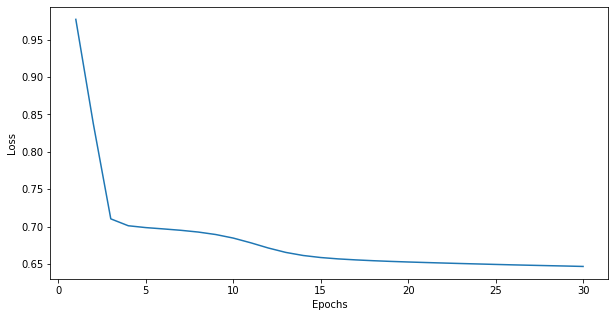

In [10]:
class VAE_AutoEncoder(nn.Module):
    def __init__(self):
        super(VAE_AutoEncoder, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12,3),
        )
        self.Decoder = nn.Sequential(
            nn.Linear(3,12),
            nn.ReLU(), 
            nn.Linear(12,64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128,28*28),
            nn.Tanh()
        )
    def forward(self,x):
        x1 = self.Encoder(x)
        x2 = self.Decoder(x1)
        return x1, x2

model = VAE_AutoEncoder().cuda()
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=0.000001)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

def variational_loss(x1, x2, data, lambda1=1e-5):
    Loss1 = loss(x2, data)
    x1.backward(torch.ones(x1.size()).cuda(), retain_graph=True)
    
    Loss2 = torch.sqrt(torch.sum(torch.pow(data.grad,2)))
    data.grad.data.zero_()
    Loss = Loss1 + lambda1*Loss2
    return Loss


def train(epochs=30):
    torch.cuda.empty_cache()
    loss_history = np.zeros(epochs)
    x_range = np.arange(1, epochs+1)
    for i in tqdm_notebook(range(epochs)):
        loss_avg = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.view(data.size(0), -1)
            data, target = data.cuda(), target.cuda()
            
            # Grads
            data.retain_grad()
            data.requires_grad_(True)

            # Forward Pass
            x1, y_hat = model(data)
            
            Loss = variational_loss(x1, y_hat, data)
            
            # Keep Sum of Loss
            loss_avg += Loss.item()
            
            data.requires_grad_(False)
            
            # Zero Gradient
            optimizer.zero_grad()
            # Backward Pass
            Loss.backward() 
            # Step Forward
            optimizer.step()
            
        # Save Loss History    
        loss_history[i] = loss_avg / len(train_loader)
        print('Epoch[{}/{}], loss:{:.4f}'.format(i+1,epochs, loss_avg/len(train_loader)))
        
        
    # Matplotlib
    plt.figure(figsize=(10,5))
    plt.plot(x_range, loss_history)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
            
            
train()

### Testing Final Layer of Encoder

In [11]:
### Testing Final Layer of Encoder
### Proceed to Test The AutoEncoder

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=1, shuffle=True)

def test():
    loss_avg = 0
    X = np.zeros((len(train_loader),3))
    X_original = np.zeros((len(train_loader), 28*28))
    Y = []
    target_list  = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(data.size(0), -1)
        data, target = data.cuda(), target.cuda()
            
        # Zero Grad
        with torch.no_grad():   
            # Forward Pass
            y_hat, x_hat = model.forward(data)

            y_hat = y_hat.detach().cpu().numpy()
            y_hat = np.asarray(y_hat)
            
            # Append Values
            X[batch_idx] = y_hat
            X_original[batch_idx] = data.detach().cpu().numpy()
            target = target.detach().cpu().numpy()
            Y.append(target)
    
    # Declare Logistic Equation
    Y = np.asarray(Y).flatten()
    
    # Original Data
    clf1 = LogisticRegression(random_state=1, max_iter=1e4).fit(X_original,Y)
    y_hat = clf1.predict(X_original)
    print("Original Accuracy: ", accuracy_score(y_hat, Y))
    
    clf = LogisticRegression(random_state=0, max_iter=1e4).fit(X, Y)
    y_hat = clf.predict(X)
    print("Training Accuracy: ", accuracy_score(y_hat, Y))
    
test()

Original Accuracy:  0.9424833333333333
Training Accuracy:  0.3991


### Testing Output of Decoder

In [12]:
def test2():
    X = np.zeros((len(train_loader),28*28))
    Y = []
    target_list  = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(data.size(0), -1)
        data, target = data.cuda(), target.cuda()
            
        # Zero Grad
        with torch.no_grad():   
            # Forward Pass
            x_hat, y_hat = model.forward(data)

            y_hat = y_hat.detach().cpu().numpy()
            y_hat = np.asarray(y_hat)
            
            # Append Values
            X[batch_idx] = y_hat
            target = target.detach().cpu().numpy()
            Y.append(target)
    
    # Declare Logistic Equation
    Y = np.asarray(Y).flatten()
    clf = LogisticRegression(random_state=0, max_iter=1e4).fit(X, Y)
    y_hat = clf.predict(X)
    
    # Print Accuracy
    print("Training Accuracy: ", accuracy_score(y_hat, Y))
    
test2()

Training Accuracy:  0.4365833333333333


## PCA Feature Extraction

In [88]:
from sklearn.decomposition import PCA

def test2():
    X = np.zeros((len(train_loader),28*28))
    Y = []
    target_list  = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(data.size(0), -1)
        data = data.detach().cpu().numpy().flatten()
        X[batch_idx] = data
        target = target.detach().cpu().numpy()
        Y.append(target)
        
    pca = None
    pca = PCA(n_components=3).fit(X)
    

    X_train_pca = pca.transform(X)    
    # Declare Logistic Equation
    Y = np.asarray(Y).flatten()
    clf = LogisticRegression(random_state=0, max_iter=1e4).fit(X_train_pca, Y)
    y_hat = clf.predict(X_train_pca)
    
    # Print Accuracy
    print("Training Accuracy: ", accuracy_score(y_hat, Y))
    
test2()

Training Accuracy:  0.46371666666666667
